# Streamlined Data Ingestion with pandas

**Connect to a database**

In order to get data from a database with pandas, you first need to be able to connect to one. In this exercise, you'll practice creating a database engine to manage connections to a database, data.db. To do this, you'll use sqlalchemy's create_engine() function.

*create_engine()* needs a string URL to the database. For SQLite databases, that string consists of "sqlite:///", then the database file name.

**Load entire tables**

*data.db* has two tables. weather has historical weather data for New York City. hpd311calls is a subset of call records made to the city's 311 help line about housing issues.

In this exercise, you'll use the read_sql() function in pandas to load both tables. read_sql() accepts a string of either a SQL query to run, or a table to load. It also needs a way to connect to the database, like the engine in the provided code.

In [20]:
import pandas as pd
from sqlalchemy import create_engine

# Create the database engine
engine = create_engine('sqlite:///data.db')

# Load hpd311calls without any SQL
hpd_calls = pd.read_sql('hpd311calls', engine)

# View the first few rows of data
hpd_calls.head()

,unique_key,created_date,agency,complaint_type,incident_zip,incident_address,community_board,borough
0,38070822,01/01/2018,HPD,HEAT/HOT WATER,10468,2786 JEROME AVENUE,07 BRONX,BRONX
1,38065299,01/01/2018,HPD,PLUMBING,10003,323 EAST 12 STREET,03 MANHATTAN,MANHATTAN
2,38066653,01/01/2018,HPD,HEAT/HOT WATER,10452,1235 GRAND CONCOURSE,04 BRONX,BRONX
3,38070264,01/01/2018,HPD,HEAT/HOT WATER,10032,656 WEST 171 STREET,12 MANHATTAN,MANHATTAN
4,38072466,01/01/2018,HPD,HEAT/HOT WATER,11213,1030 PARK PLACE,08 BROOKLYN,BROOKLYN


**Selecting columns with SQL**

After making a database engine, you'll write a query to SELECT only the date and temperature columns, and pass both to read_sql() to make a data frame of high and low temperature readings.

In [21]:
# Write query to get date, tmax, and tmin from weather
query = """
SELECT date, 
       tmax, 
       tmin
  FROM weather;
"""

# Make a data frame by passing query and engine to read_sql()
temperatures = pd.read_sql(query, engine)

# View the resulting data frame
print(temperatures)

           date  tmax  tmin
0    12/01/2017    52    42
1    12/02/2017    48    39
2    12/03/2017    48    42
3    12/04/2017    51    40
4    12/05/2017    61    50
..          ...   ...   ...
116  03/27/2018    47    34
117  03/28/2018    52    38
118  03/29/2018    53    49
119  03/30/2018    62    44
120  03/31/2018    58    39

[121 rows x 3 columns]


**Selecting rows**

The hpd311calls table in data.db has data on calls about various housing issues, from maintenance problems to information requests. In this exercise, you'll use SQL to focus on calls about safety.

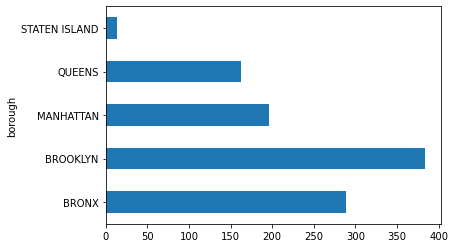

In [22]:
# Create query to get hpd311calls records about safety
query = """
SELECT *
FROM hpd311calls
WHERE complaint_type = 'SAFETY' ;
"""

# Query the database and assign result to safety_calls
safety_calls = pd.read_sql(query, engine)

# Graph the number of safety calls by borough
call_counts = safety_calls.groupby('borough').unique_key.count()
call_counts.plot.barh()
plt.show()

**Filtering on multiple conditions**

Let's focus on inclement weather, where there was either an inch or more of snow or the high was at or below freezing (32° Fahrenheit)

In [23]:
# Create query for records with max temps <= 32 or snow >= 1
query = """
SELECT *
  FROM weather
  WHERE tmax <= 32 
  OR snow >= 1;
"""

# Query database and assign result to wintry_days
wintry_days = pd.read_sql(query, engine)

# View summary stats about the temperatures
print(wintry_days.describe())

           latitude     longitude     elevation       awnd      prcp  \
count  2.500000e+01  2.500000e+01  2.500000e+01  25.000000  25.00000   
mean   4.077898e+01 -7.396925e+01  4.270000e+01   7.739600   0.17600   
std    2.175584e-14  4.351168e-14  1.450389e-14   2.621778   0.36947   
min    4.077898e+01 -7.396925e+01  4.270000e+01   3.130000   0.00000   
25%    4.077898e+01 -7.396925e+01  4.270000e+01   5.820000   0.00000   
50%    4.077898e+01 -7.396925e+01  4.270000e+01   7.830000   0.00000   
75%    4.077898e+01 -7.396925e+01  4.270000e+01   9.170000   0.09000   
max    4.077898e+01 -7.396925e+01  4.270000e+01  12.970000   1.41000   

            snow       tmax       tmin  
count  25.000000  25.000000  25.000000  
mean    1.332000  27.320000  17.160000  
std     2.685256   7.122266   7.673982  
min     0.000000  13.000000   5.000000  
25%     0.000000  22.000000  11.000000  
50%     0.000000  28.000000  17.000000  
75%     1.200000  31.000000  20.000000  
max     9.800000  40.00

**Getting distinct values**

Since hpd311calls contains data about housing issues, we would expect most records to have a borough listed. Let's test this assumption by querying unique complaint_type/borough combinations.

In [24]:
# Create query for unique combinations of borough and complaint_type
query = """
SELECT DISTINCT borough, 
       complaint_type
  FROM hpd311calls;
"""

# Load results of query to a data frame
issues_and_boros = pd.read_sql(query, engine)

# Check assumption about issues and boroughs
print(issues_and_boros)

          borough    complaint_type
0           BRONX    HEAT/HOT WATER
1       MANHATTAN          PLUMBING
2       MANHATTAN    HEAT/HOT WATER
3        BROOKLYN    HEAT/HOT WATER
4          QUEENS    HEAT/HOT WATER
..            ...               ...
60      MANHATTAN  OUTSIDE BUILDING
61      MANHATTAN          ELEVATOR
62       BROOKLYN  OUTSIDE BUILDING
63  STATEN ISLAND            SAFETY
64  STATEN ISLAND  OUTSIDE BUILDING

[65 rows x 2 columns]


**Counting in groups**

The hpd311calls table has a column, complaint_type, that categorizes call records by issue, such as heating or plumbing. In order to graph call volumes by issue, you'll write a SQL query that COUNTs records by complaint type.

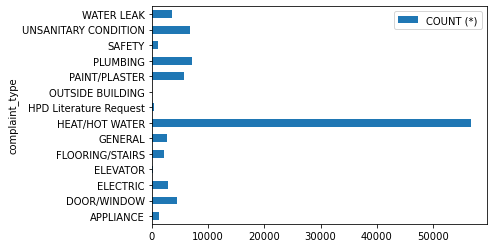

In [25]:
# Create query to get call counts by complaint_type
query = """
SELECT complaint_type, 
     COUNT (*)
  FROM hpd311calls
  GROUP BY complaint_type;
"""

# Create data frame of call counts by issue
calls_by_issue = pd.read_sql(query, engine)

# Graph the number of calls for each housing issue
calls_by_issue.plot.barh(x="complaint_type")
plt.show()

**Joining tables**

The records in hpd311calls often concern issues, like leaks or heating problems, that are exacerbated by weather conditions. In this exercise, you'll join weather data to call records along their common date columns to get everything in one data frame

In [26]:
# Query to join weather to call records by date columns
query = """
SELECT * 
  FROM hpd311calls
  JOIN weather 
  ON hpd311calls.created_date = weather.date;
"""

# Create data frame of joined tables
calls_with_weather = pd.read_sql(query, engine)

# View the data frame to make sure all columns were joined
print(calls_with_weather.head())

  unique_key created_date agency  complaint_type incident_zip  \
0   38070822   01/01/2018    HPD  HEAT/HOT WATER        10468   
1   38065299   01/01/2018    HPD        PLUMBING        10003   
2   38066653   01/01/2018    HPD  HEAT/HOT WATER        10452   
3   38070264   01/01/2018    HPD  HEAT/HOT WATER        10032   
4   38072466   01/01/2018    HPD  HEAT/HOT WATER        11213   

       incident_address community_board    borough      station  \
0    2786 JEROME AVENUE        07 BRONX      BRONX  USW00094728   
1  323 EAST   12 STREET    03 MANHATTAN  MANHATTAN  USW00094728   
2  1235 GRAND CONCOURSE        04 BRONX      BRONX  USW00094728   
3  656 WEST  171 STREET    12 MANHATTAN  MANHATTAN  USW00094728   
4       1030 PARK PLACE     08 BROOKLYN   BROOKLYN  USW00094728   

                          name  ...  longitude  elevation        date  \
0  NY CITY CENTRAL PARK, NY US  ...  -73.96925       42.7  01/01/2018   
1  NY CITY CENTRAL PARK, NY US  ...  -73.96925       42.7  0

In [27]:
# Query to get water leak calls and daily precipitation
query = """
SELECT hpd311calls.*, weather.prcp
  FROM hpd311calls
  JOIN weather
    ON hpd311calls.created_date = weather.date
  WHERE hpd311calls.complaint_type = 'WATER LEAK';"""

# Load query results into the leak_calls data frame
leak_calls = pd.read_sql(query, engine)

# View the data frame
print(leak_calls.head())

  unique_key created_date agency complaint_type incident_zip  \
0   38074305   01/01/2018    HPD     WATER LEAK        11212   
1   38078748   01/01/2018    HPD     WATER LEAK        10458   
2   38081097   01/01/2018    HPD     WATER LEAK        11221   
3   38077874   01/01/2018    HPD     WATER LEAK        11418   
4   38081110   01/01/2018    HPD     WATER LEAK        11420   

          incident_address community_board   borough  prcp  
0     1026 WILLMOHR STREET     17 BROOKLYN  BROOKLYN   0.0  
1       2700 MARION AVENUE        07 BRONX     BRONX   0.0  
2  192 MALCOLM X BOULEVARD     03 BROOKLYN  BROOKLYN   0.0  
3    129-11 JAMAICA AVENUE       09 QUEENS    QUEENS   0.0  
4        111-17 133 STREET       10 QUEENS    QUEENS   0.0  


**Joining, filtering, and aggregating**

In this exercise, you'll use what you've learned to assemble a dataset to investigate how the number of heating complaints to New York City's 311 line varies with temperature.

In addition to the hpd311calls table, data.db has a weather table with daily high and low temperature readings for NYC. We want to get each day's count of heat/hot water calls with temperatures joined in.

In [28]:
# Modify query to join tmax and tmin from weather by date
query = """
SELECT hpd311calls.created_date, 
	   COUNT(*), 
       weather.tmax,
       weather.tmin
  FROM hpd311calls 
       JOIN weather
       ON hpd311calls.created_date = weather.date
 WHERE hpd311calls.complaint_type = 'HEAT/HOT WATER' 
 GROUP BY hpd311calls.created_date;
 """

# Query database and save results as df
df = pd.read_sql(query, engine)

# View first 5 records
print(df.head())

  created_date  COUNT(*)  tmax  tmin
0   01/01/2018      4597    19     7
1   01/02/2018      4362    26    13
2   01/03/2018      3045    30    16
3   01/04/2018      3374    29    19
4   01/05/2018      4333    19     9
